## Bic Vu's Capstone Project
#### ML Guild - Apprentice Cohort 11
#### Notebook 3
2023-04-13

In [50]:
import pandas as pd
import pandas_profiling as pf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 12)

In [29]:
df = pd.read_parquet("data/output/black_features_20230414_aggZip")
print(df.shape)
df.head()

(13203, 18)


,zip,census_tract,approval_black,loan_amount,property_value,income,tract_minority_population_percent,income_level,dti_level,num_below_p50,pop2018,ec_zip,nbhd_ec_zip,exposure_grp_mem_zip,nbhd_exposure_zip,clustering_zip,volunteering_rate_zip,civic_organizations_zip
0,01001,25013813204,0.958333333333,255833.333333333343,322500.000000000000,86.625000000000,11.288333333333,middle,20%-<30%,995.787467956543,17621.0,0.88156998,1.51095000,1.12959,1.50590000,0.105720000,0.056499999,0.0108000000
1,01002,25011040600,0.769047619048,278476.190476190473,390380.952380952367,125.159523809524,22.026000000000,upper,42%-<50%,1312.117076873779,30066.0,1.18348000,0.97759998,1.36818,1.20281990,0.103400000,0.149510000,0.0368800010
2,01005,25027704200,0.750000000000,235625.000000000000,295625.000000000000,93.750000000000,5.095000000000,middle,42%-<50%,381.519744873047,4991.0,1.15543000,1.46491000,1.31876,1.46396990,0.105540000,0.158620000,0.0216300000
3,01007,25015820203,0.916666666667,300416.666666666628,356250.000000000000,91.041666666667,6.835000000000,middle,30%-<36%,915.396667480469,14967.0,1.19240000,1.17985000,1.30741,1.23108990,0.103910000,0.130530000,0.0168999990
4,01013,25013800400,0.781014717509,200336.434957124613,264251.961320926843,68.128094021772,30.257777777778,moderate,36%-<42%,2616.550354003906,23065.0,0.69744003,0.53930002,0.87842,0.67602003,0.086479999,0.061910000,0.0096899997


In [30]:
# Separate out dti_level to encode bc of name error
# df = pd.get_dummies(df, columns = ["income_level","dti_level"], prefix=["inc_", "dti_"])
dti = df[["dti_level"]]
dti = pd.get_dummies(dti, columns = ["dti_level"])
dti.head()

,dti_level_20%-<30%,dti_level_30%-<36%,dti_level_36%-<42%,dti_level_42%-<50%,dti_level_50%-60%,dti_level_<20%,dti_level_>60%
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0


In [31]:
# XGBoost does not like special characters in columns name. Well isn't that just grand.
dti.columns=["dti_20", "dti_30", "dti_36", "dti_42", "dti_50", "dti_0", "dti_60"]
dti.head()

,dti_20,dti_30,dti_36,dti_42,dti_50,dti_0,dti_60
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0


In [32]:
df = df.drop("dti_level", axis=1)
df = pd.get_dummies(df, columns = ["income_level"])
df.head()

,zip,census_tract,approval_black,loan_amount,property_value,income,tract_minority_population_percent,num_below_p50,pop2018,ec_zip,nbhd_ec_zip,exposure_grp_mem_zip,nbhd_exposure_zip,clustering_zip,volunteering_rate_zip,civic_organizations_zip,income_level_low,income_level_middle,income_level_moderate,income_level_nan,income_level_upper
0,01001,25013813204,0.958333333333,255833.333333333343,322500.000000000000,86.625000000000,11.288333333333,995.787467956543,17621.0,0.88156998,1.51095000,1.12959,1.50590000,0.105720000,0.056499999,0.0108000000,0,1,0,0,0
1,01002,25011040600,0.769047619048,278476.190476190473,390380.952380952367,125.159523809524,22.026000000000,1312.117076873779,30066.0,1.18348000,0.97759998,1.36818,1.20281990,0.103400000,0.149510000,0.0368800010,0,0,0,0,1
2,01005,25027704200,0.750000000000,235625.000000000000,295625.000000000000,93.750000000000,5.095000000000,381.519744873047,4991.0,1.15543000,1.46491000,1.31876,1.46396990,0.105540000,0.158620000,0.0216300000,0,1,0,0,0
3,01007,25015820203,0.916666666667,300416.666666666628,356250.000000000000,91.041666666667,6.835000000000,915.396667480469,14967.0,1.19240000,1.17985000,1.30741,1.23108990,0.103910000,0.130530000,0.0168999990,0,1,0,0,0
4,01013,25013800400,0.781014717509,200336.434957124613,264251.961320926843,68.128094021772,30.257777777778,2616.550354003906,23065.0,0.69744003,0.53930002,0.87842,0.67602003,0.086479999,0.061910000,0.0096899997,0,0,1,0,0


In [33]:
df = pd.merge(df, dti, left_index=True, right_index=True)
df.head()

,zip,census_tract,approval_black,loan_amount,property_value,income,tract_minority_population_percent,num_below_p50,pop2018,ec_zip,nbhd_ec_zip,exposure_grp_mem_zip,nbhd_exposure_zip,clustering_zip,volunteering_rate_zip,civic_organizations_zip,income_level_low,income_level_middle,income_level_moderate,income_level_nan,income_level_upper,dti_20,dti_30,dti_36,dti_42,dti_50,dti_0,dti_60
0,01001,25013813204,0.958333333333,255833.333333333343,322500.000000000000,86.625000000000,11.288333333333,995.787467956543,17621.0,0.88156998,1.51095000,1.12959,1.50590000,0.105720000,0.056499999,0.0108000000,0,1,0,0,0,1,0,0,0,0,0,0
1,01002,25011040600,0.769047619048,278476.190476190473,390380.952380952367,125.159523809524,22.026000000000,1312.117076873779,30066.0,1.18348000,0.97759998,1.36818,1.20281990,0.103400000,0.149510000,0.0368800010,0,0,0,0,1,0,0,0,1,0,0,0
2,01005,25027704200,0.750000000000,235625.000000000000,295625.000000000000,93.750000000000,5.095000000000,381.519744873047,4991.0,1.15543000,1.46491000,1.31876,1.46396990,0.105540000,0.158620000,0.0216300000,0,1,0,0,0,0,0,0,1,0,0,0
3,01007,25015820203,0.916666666667,300416.666666666628,356250.000000000000,91.041666666667,6.835000000000,915.396667480469,14967.0,1.19240000,1.17985000,1.30741,1.23108990,0.103910000,0.130530000,0.0168999990,0,1,0,0,0,0,1,0,0,0,0,0
4,01013,25013800400,0.781014717509,200336.434957124613,264251.961320926843,68.128094021772,30.257777777778,2616.550354003906,23065.0,0.69744003,0.53930002,0.87842,0.67602003,0.086479999,0.061910000,0.0096899997,0,0,1,0,0,0,0,1,0,0,0,0


#### OneHotEncoder method

In [ ]:
# ohe = OneHotEncoder(sparse=False)
# result = ohe.fit_transform(df)

In [ ]:
# # print(ohe.categories_)
# # print(result)
# print(pd.DataFrame(result, columns=ohe.categories_))

### XGBoost
<p>https://machinelearningmastery.com/xgboost-for-regression/

In [34]:
# check xgboost version
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score

print(xgb.__version__)

1.7.4


In [35]:
# Define features
# X = df.iloc[:, 7:]
X = df.drop(["approval_black", "pop2018","zip"], axis=1).set_index("census_tract")

# Define target
y = df[["approval_black","census_tract"]].set_index("census_tract")

In [36]:
X.head()

,loan_amount,property_value,income,tract_minority_population_percent,num_below_p50,ec_zip,nbhd_ec_zip,exposure_grp_mem_zip,nbhd_exposure_zip,clustering_zip,volunteering_rate_zip,civic_organizations_zip,income_level_low,income_level_middle,income_level_moderate,income_level_nan,income_level_upper,dti_20,dti_30,dti_36,dti_42,dti_50,dti_0,dti_60
census_tract,,,,,,,,,,,,,,,,,,,,,,,,
25013813204,255833.333333333343,322500.000000000000,86.625000000000,11.288333333333,995.787467956543,0.88156998,1.51095000,1.12959,1.50590000,0.105720000,0.056499999,0.0108000000,0,1,0,0,0,1,0,0,0,0,0,0
25011040600,278476.190476190473,390380.952380952367,125.159523809524,22.026000000000,1312.117076873779,1.18348000,0.97759998,1.36818,1.20281990,0.103400000,0.149510000,0.0368800010,0,0,0,0,1,0,0,0,1,0,0,0
25027704200,235625.000000000000,295625.000000000000,93.750000000000,5.095000000000,381.519744873047,1.15543000,1.46491000,1.31876,1.46396990,0.105540000,0.158620000,0.0216300000,0,1,0,0,0,0,0,0,1,0,0,0
25015820203,300416.666666666628,356250.000000000000,91.041666666667,6.835000000000,915.396667480469,1.19240000,1.17985000,1.30741,1.23108990,0.103910000,0.130530000,0.0168999990,0,1,0,0,0,0,1,0,0,0,0,0
25013800400,200336.434957124613,264251.961320926843,68.128094021772,30.257777777778,2616.550354003906,0.69744003,0.53930002,0.87842,0.67602003,0.086479999,0.061910000,0.0096899997,0,0,1,0,0,0,0,1,0,0,0,0


In [37]:
y.head()

,approval_black
census_tract,
25013813204,0.958333333333
25011040600,0.769047619048
25027704200,0.750000000000
25015820203,0.916666666667
25013800400,0.781014717509


In [38]:
# Set random seed
seed = random.seed(42)
test_size = 0.3 # 70% will go to train

# split data into train and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=seed)

In [39]:
# split temporary data into test and validation sets
# Final result should be 70% train, 15% test, and 15% validation
test_size = 0.5
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=test_size, random_state=seed)

In [40]:
X_train.dtypes

loan_amount                          float64
property_value                       float64
income                               float64
tract_minority_population_percent    float64
num_below_p50                        float64
ec_zip                               float64
nbhd_ec_zip                          float64
exposure_grp_mem_zip                 float64
nbhd_exposure_zip                    float64
clustering_zip                       float64
volunteering_rate_zip                float64
civic_organizations_zip              float64
income_level_low                       uint8
income_level_middle                    uint8
income_level_moderate                  uint8
income_level_nan                       uint8
income_level_upper                     uint8
dti_20                                 uint8
dti_30                                 uint8
dti_36                                 uint8
dti_42                                 uint8
dti_50                                 uint8
dti_0     

In [41]:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRFRegressor

from sklearn.metrics import mean_absolute_error

model = XGBRegressor(
    n_estimators=1000,
    max_depth = 20,
    random_state = seed,
    early_stopping_rounds=10
#     enable_categorial=True
)

model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:0.24667
[1]	validation_0-rmse:0.21294
[2]	validation_0-rmse:0.19378
[3]	validation_0-rmse:0.18386
[4]	validation_0-rmse:0.17874
[5]	validation_0-rmse:0.17589
[6]	validation_0-rmse:0.17463
[7]	validation_0-rmse:0.17400
[8]	validation_0-rmse:0.17361
[9]	validation_0-rmse:0.17340
[10]	validation_0-rmse:0.17349
[11]	validation_0-rmse:0.17347
[12]	validation_0-rmse:0.17354
[13]	validation_0-rmse:0.17358
[14]	validation_0-rmse:0.17353
[15]	validation_0-rmse:0.17340
[16]	validation_0-rmse:0.17349
[17]	validation_0-rmse:0.17355
[18]	validation_0-rmse:0.17354
[19]	validation_0-rmse:0.17353
[20]	validation_0-rmse:0.17355
[21]	validation_0-rmse:0.17356
[22]	validation_0-rmse:0.17354
[23]	validation_0-rmse:0.17356
[24]	validation_0-rmse:0.17357
[25]	validation_0-rmse:0.17358


### Create predictions and compare with actuals

In [42]:
X_test["predictions"] = model.predict(X_test)

In [43]:
test_df = y_test.merge(X_test["predictions"], on="census_tract")
test_df.head()

,approval_black,predictions
census_tract,,
27157490500,0.750000000000,0.910900294781
09007610200,1.000000000000,0.823428630829
06037141700,0.788888888889,0.795390069485
51093280101,0.734090093434,0.772353529930
17113005102,1.000000000000,0.848502397537


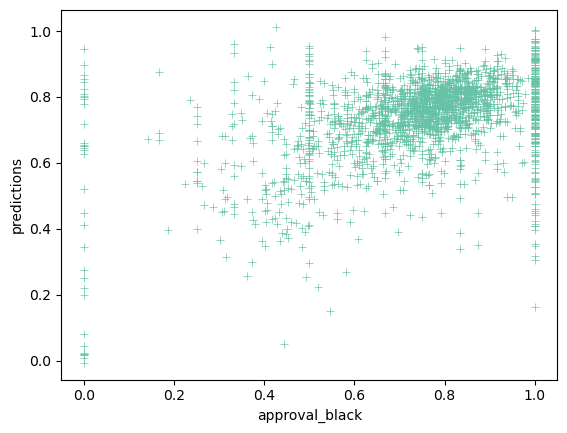

In [44]:
# scatter plot. x = true value, y = predictions
from datetime import date
today = date.today()

sns.set_palette("Set2")
actuals = test_df["approval_black"]
predictions = test_df["predictions"]
scatter = sns.scatterplot(data=test_df, x=actuals, y=predictions, marker="+")
# scatter.figure.savefig("charts/scatter_actuals-predictions-"+str(today)+".png")

#### Calculate differences in actauls and predictions

In [ ]:
# test_df["diff"] = test_df["approval_black"] - test_df["predictions"]
# test_df.head()

In [ ]:
# max5 =test_df.nlargest(5,['diff'])
# max5

### Shap

In [19]:
# SHAP value to explain model
# plot beeswarm of features
# plot force plot for 5 best (smallest diff between prediction and actual) and 5 worst predictions (largest diff)

import shap
shap.initjs()

In [45]:
# Explain the model's prediction using SHAP
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

 99%|===================| 1968/1980 [00:11<00:00]       

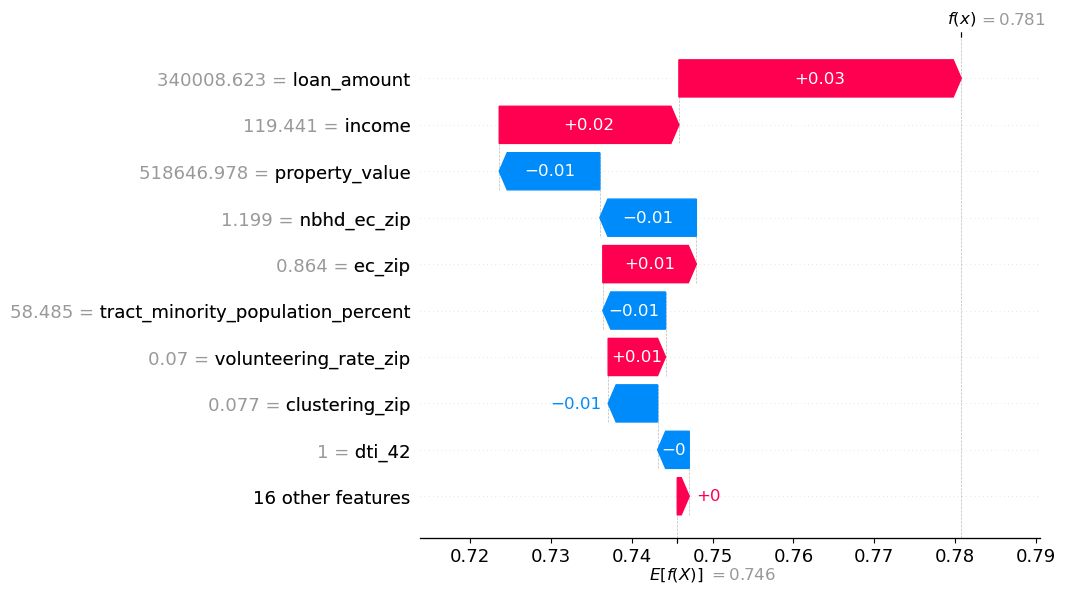

In [46]:
# Visualize the first predictions's explaination
shap.plots.waterfall(shap_values[101])

In [47]:
shap.plots.force(shap_values[101])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


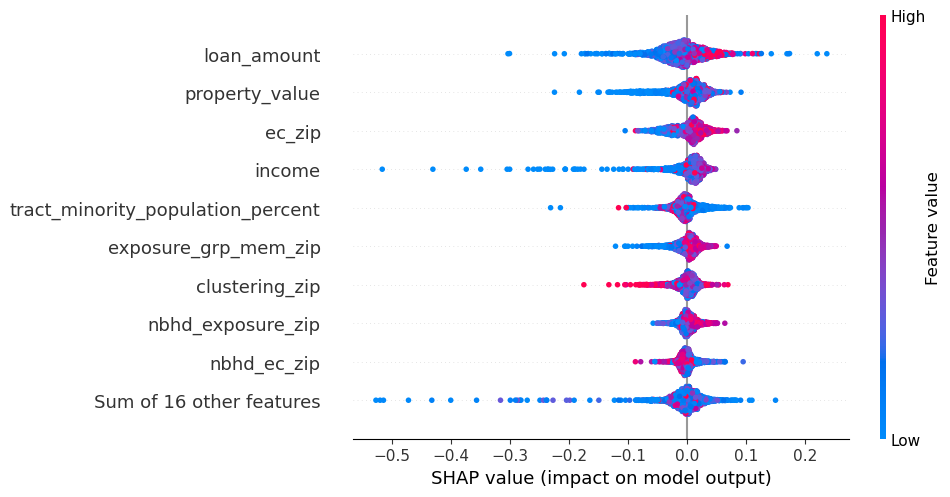

In [48]:
# Beeswarm
shap.plots.beeswarm(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


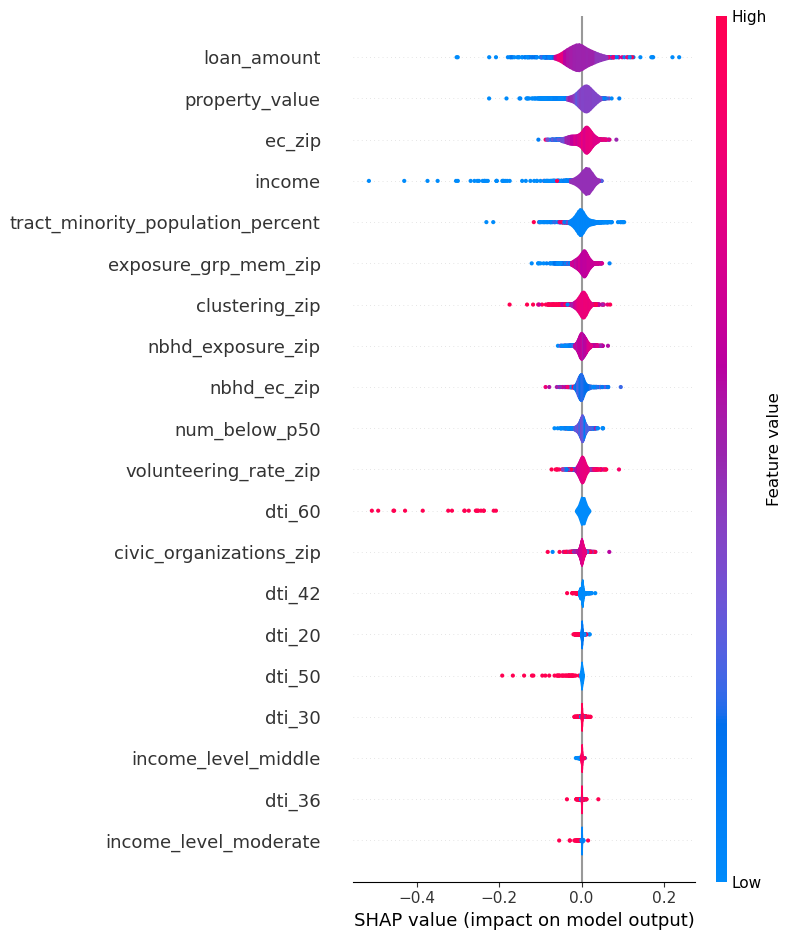

In [49]:
# Violin plot shows similar results with some segment colors blended together
shap.summary_plot(shap_values, plot_type="violin")